# Classification Assignment

The main goal of this assignment is to check in on your ability to access, load, explore, and make predictions using classification models.  For next Wednesday, you are to do the following:

1. Locate a dataset on Kaggle, NYC Open Data, UCI Machine Learning Repository, or other resource that contains data that can be addressed through a classification task (Done)
2. Load and explore the data for missing values and perform a brief EDA (Done)
3. Frame and state the classification problem (Done)
4. Split your data into train and test sets (Done)
4. Implement a `DummyClassifier`, `KNeighborsClassifier`, and `LogisticRegression` model. (Done)
5. Improve the models by performing a `GridSearchCV` for `n_neighbors` and `C` parameters respectively.  Include a scale transformation in your pipeline for KNN and a `PolynomialFeatures` step in the Logistic model. (Partly Done)
6. Discuss the outcome of your classifiers using the `classification_report`.  Which did the best?  Do you prefer a recall or a precision oriented model?  Why? 

**EXTRA**:

- Include `SGDClassifier`
- Incorporate AUC and ROC curves


## Credit Card Default Dictionary Information: ##

**This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:**

* LIMIT_BAL: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
* SEX: Gender (1 = male; 2 = female). 
* EDUCATION: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
* MARRIAGE: Marital status (1 = married; 2 = single; 3 = others). 
* AGE: Age (year). 
* PAY0 - PAY6: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* BILL_AMT1 - BILL_AMT6 : Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
* PAY_AMT1-PAY_AMT6: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005. 



In [57]:
#Import most packages we'll need 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

In [58]:
# Read data in
data = pd.read_csv("../data/Credit_Data.csv")

In [60]:
#Explore data to see if there's any missing or unclean data (fortunately it's clean)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30001 entries, 0 to 30000
Data columns (total 25 columns):
Unnamed: 0    30001 non-null object
X1            30001 non-null object
X2            30001 non-null object
X3            30001 non-null object
X4            30001 non-null object
X5            30001 non-null object
X6            30001 non-null object
X7            30001 non-null object
X8            30001 non-null object
X9            30001 non-null object
X10           30001 non-null object
X11           30001 non-null object
X12           30001 non-null object
X13           30001 non-null object
X14           30001 non-null object
X15           30001 non-null object
X16           30001 non-null object
X17           30001 non-null object
X18           30001 non-null object
X19           30001 non-null object
X20           30001 non-null object
X21           30001 non-null object
X22           30001 non-null object
X23           30001 non-null object
Y             30001 non-nul

In [61]:
#View the first few rows to get a sense of the data

data.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [62]:
# Drop the first row because "X1" and "X2" etc. are confusing, made the first row the headers

data.columns = data.iloc[0]

data = data[1:]

In [9]:
# Update column name to remove spaces

data.head()

data.rename(columns={'default payment next month': "Default_Next_Month"}, inplace=True)

In [10]:
#Make all data numeric

for item in data.columns:
    data[item] = pd.to_numeric(data[item])

0    23364
1     6636
Name: Default_Next_Month, dtype: int64

In [63]:
# Create a missed payment column feature, based on previous paymen history columns
# Any positive values mean a payment was missed, so anything > 0 is a missed payment
# Then convert the boolean to an integer value to be evaluated

data["Missed_Payment_History"] = (data["PAY_0"] + data["PAY_2"] + data["PAY_3"] + 
                                  data["PAY_4"] + data["PAY_5"] + data["PAY_6"])

data["Missed_Payment_Int"] = data["Missed_Payment_History"] > 0


for item in data["Missed_Payment_Int"]:
    data["Missed_Payment_Int"] = (data['Missed_Payment_Int'].astype(int))

    

TypeError: '>' not supported between instances of 'str' and 'int'

In [64]:
#Explore data again to ensure columns were added correctly
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,Missed_Payment_History
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,689,0,0,0,0,1,22-1-1-2-2
2,2,120000,2,2,2,26,-1,2,0,0,...,3455,3261,0,1000,1000,1000,0,2000,1,-120002
3,3,90000,2,2,2,34,0,0,0,0,...,14948,15549,1518,1500,1000,1000,1000,5000,0,000000
4,4,50000,2,2,1,37,0,0,0,0,...,28959,29547,2000,2019,1200,1100,1069,1000,0,000000
5,5,50000,1,2,1,57,-1,0,-1,0,...,19146,19131,2000,36681,10000,9000,689,679,0,-10-1000


Text(0.5,1,'# of Males vs Females in Dataset')

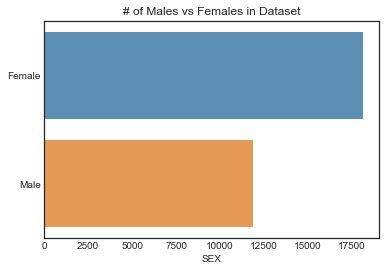

In [22]:
#EDA looking at the breakdown of gender in the dataset

sex_count = data["SEX"].value_counts()
gender = ["Female", "Male"]
sns.despine()
sns.set_style("white")

gender_chart = sns.barplot(sex_count, gender, alpha=0.8)
gender_chart.set_title("# of Males vs Females in Dataset")

Text(0.5,1,'# of Married vs Single CC Holders in Dataset')

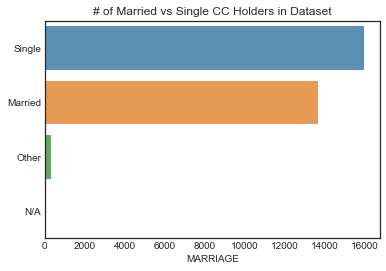

In [23]:
#EDA looking at the breakdown of marriage in the dataset

marriage_counts = data["MARRIAGE"].value_counts()
marriage_type = ["Single", "Married", "Other", "N/A"]

marriage_chart = sns.barplot(marriage_counts, marriage_type, alpha=0.8)
marriage_chart.set_title("# of Married vs Single CC Holders in Dataset")



Text(0,0.5,'# of People in Dataset')

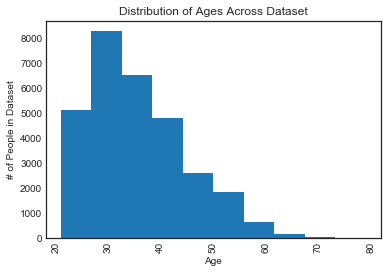

In [24]:
#EDA histogram looking at the breakdown of age distribution in the dataset


from matplotlib.pyplot import subplots
fig, ax = subplots()

age_chart = plt.hist(data["AGE"])

plt.title("Distribution of Ages Across Dataset")
ax.set_xlabel("Age")
plt.xticks(rotation=90)
ax.set_ylabel("# of People in Dataset")

In [25]:
#EDA looking at some basic stats of age in the dataset


age_avg = data["AGE"].mean()
age_median = data["AGE"].median()
age_min = data["AGE"].min()
age_max = data["AGE"].max()

output_str = "The average age is: {0:.2f}  and the median age is {1:.2f} in the dataset. The min and max are {2:.2f} and {3:.2f}."
print(output_str.format(age_avg, age_median, age_min, age_max))




The average age is: 35.49  and the median age is 34.00 in the dataset. The min and max are 21.00 and 79.00.


## Results ##

From our quick EDA we can see:
* The data set is majority female vs male, with ~60% of the dataset being female and 40% being male
* The majority of the dataset is single versus married, with ~53% married, ~43% single and the rest are other
* The distribution of age ranges from 21 years to 79 years, with the average being 35.49 years and the median being 34 years of age

## Classification Statement Problem ##

We want to be able to see if people are more likely to default on their payment based on their:
* Marriage Status
* Education Level
* Age
* Previous history of missed payment (Need to add column, averaging how many missed payment months)

The question is, will a person, be more likely to default based on the above factors?


## Modeling Workflow ##
1. **Initiate & Split** into training & test data
2. **Fit** to *training* data
3. **Predict** using *test* data
4. **Evaluate** how model did
5. **Repeat** for other models

## Logistic Model ##

In [34]:
# This will initiate our X and Y that we care about and split our data into training and testing data
model_list = ["AGE", "MARRIAGE", "EDUCATION", "Missed_Payment_Int"]
X = data[model_list]
y = data["Default_Next_Month"]

X_train, X_test, y_train, y_test = train_test_split(X, y, )

In [35]:
# This will initiate a logistic regression model and create a model based on our training data

lm = LogisticRegression()

model = lm.fit(X_train, y_train)

preds = lm.predict(X_test)

In [65]:
# This gives us an R-squared score for our model
lm.score(X_test, y_test)

0.7766666666666666

## KNeighborsClassifier ##

## Modeling Workflow ##
1. **Initiate & Split** into training & test data
2. **Fit** to *training* data
3. **Predict** using *test* data
4. **Evaluate** how model did
5. **Repeat** for other models

In [37]:
from sklearn.neighbors import KNeighborsClassifier

X2 = data[model_list]
y2 = data["Default_Next_Month"]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2)


neighbors = KNeighborsClassifier(n_neighbors = 1, weights = 'uniform')


In [38]:
neighbors.fit(X2_train, y2_train)

preds2 = neighbors.predict(X2_test)

In [39]:
# This gives us an R-squared score for our model

neighbors.score(X2_test, y2_test)

0.7134666666666667

## DummyClassifier ##

## Modeling Workflow ##
1. **Initiate & Split** into training & test data
2. **Fit** to *training* data
3. **Predict** using *test* data
4. **Evaluate** how model did
5. **Repeat** for other models

In [51]:
from sklearn.dummy import DummyClassifier

X3 = data[model_list]
y3 = data["Default_Next_Month"]

dummy_model = DummyClassifier()

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3)


In [52]:
dummy_model.fit(X3_train, y3_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [53]:
preds3 = dummy_model.predict(X3_test)

In [54]:
# This gives us an R-squared score for our model

dummy_model.score(X3_test, y3_test)

0.6428

## Automated Improvements - PolynomialFeatures / Degrees ##

As a refresher:
* Improve the models by performing a `GridSearchCV` for `n_neighbors` and `C` parameters respectively.  Include a scale transformation in your pipeline for KNN and a `PolynomialFeatures` step in the Logistic model.

In [128]:
pipe = make_pipeline(PolynomialFeatures(), LogisticRegression())

In [66]:
# Note you can import this instead to skip a pipeline
# from sklearn.linear_model import LogisticRegressionCV

In [153]:
params = {'polynomialfeatures__degree': [i for i in range(1, 10)],
          'logisticregression__C': [0.1, 1, 5, 10, 100]}

In [154]:
grid = GridSearchCV(pipe, param_grid=params)

#Note - workflow below if you skip a pipeline
# lr = LogisticRegression()
# degree_list = [0.1, 1, 5, 10, 100]
# grid = GridSearchCV(lr, param_grid = degree_list)

In [155]:
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'logisticregression__C': [0.1, 1, 5, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [156]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False)), ('logisticregression', LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [157]:
best = grid.best_estimator_

In [158]:
# Below is the R-squared score of our grid estimated best model

best_fit = best.fit(X_train, y_train)
grid_pred = best.predict(X_test)

best_fit.score(X_test, y_test)

0.7829333333333334

In [137]:
from sklearn.model_selection import GridSearchCV

params = {'n_neighbors': [i for i in range(1, 11)]}

grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, scoring = 'mean_squared_error')

In [138]:
grid.fit(X2_train, y2_train)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/m

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/m

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='mean_squared_error', verbose=0)

In [139]:
grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [148]:
best2 = grid.best_estimator_

In [150]:
best2_fit = best2.fit(X2_train, y2_train)

In [152]:
# Below is the R-squared score of our grid estimated best model

grid_pres2 = best2.predict(X2_test)

best2_fit.score(X2_test, y2_test)

0.7721333333333333

In [162]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

std_scaled = StandardScaler()
minmax_scaled = MinMaxScaler()

In [163]:
cols = data.columns

In [164]:
std_df = std_scaled.fit_transform(data[[name for name in cols]])
minmax_df = minmax_scaled.fit_transform(data[[name for name in cols]])

In [165]:
grid = GridSearchCV(pipe, param_grid=params, cv=5)

In [166]:
#Scalar causing issues, will need to troubleshoot

grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
grid.best_estimator_

In [ ]:
best = grid.best_estimator_

In [ ]:
pred = best.predict(X_test)

In [56]:
# Evaluate all models below

from sklearn.metrics import classification_report

print("Logistic Regression Model: ")
print(classification_report(y_test, preds))

print("Kneighbors Classifier Model: ")
print(classification_report(y2_test, preds2))

print("Dummy Classifier Model: ")

print(classification_report(y3_test, preds3))

Logistic Regression Model: 
             precision    recall  f1-score   support

          0       0.80      0.94      0.87      5840
          1       0.49      0.20      0.28      1660

avg / total       0.73      0.78      0.74      7500

Kneighbors Classifier Model: 
             precision    recall  f1-score   support

          0       0.80      0.84      0.82      5826
          1       0.33      0.28      0.31      1674

avg / total       0.70      0.71      0.71      7500

Dummy Classifier Model: 
             precision    recall  f1-score   support

          0       0.78      0.78      0.78      5859
          1       0.20      0.20      0.20      1641

avg / total       0.65      0.65      0.65      7500



## Outcome / Results ##

Based on our models and the resulting classification reports, we can infer the following:
* Our model is slightly better than the dummy baseline model. In particular, our Logistic Regression Model gave us the best results
* Our Logistic Regression model unfortunately only correctly predicted default 20% of the time. Of those predicted as defaulting, we were right 49% of the time.

For improvements, I suggest getting more granular with our "Missed Payment History" column and exploring if we can more accurately predict default based on the "scale" of your defaulting, versus just lumping everyone that has a missed payment into a "1" default value